In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

import scipy.stats as stats

In [154]:
# Load the CSV file
file_train_path = './SYL/Training_SYL_All_30.csv'
file_test_path = './SYL/Testing_SYL_All.csv'

test_data = pd.read_csv(file_test_path)
train_data = pd.read_csv(file_train_path)

training_summary = train_data.describe()
testing_summary = test_data.describe()

train_data.head(), test_data.head(), training_summary.iloc[:, :10], testing_summary.iloc[:, :10]

(   MAC1  MAC2  MAC3  MAC4  MAC5  MAC6  MAC7  MAC8  MAC9  MAC10  ...  MAC362  \
 0   -74   -65   -57   -67   -79   -49   -75   -49   -73    -82  ...     100   
 1   -74   -65   -57   -67   -79   -49   -75   -49   -73    -82  ...     100   
 2   -74   -65   -57   -67   -79   -49   -75   -49   -73    -82  ...     100   
 3   -74   -65   -57   -67   -79   -49   -75   -49   -73    -82  ...     100   
 4   -74   -65   -57   -67   -79   -49   -75   -49   -73    -82  ...     100   
 
    MAC363  ECoord  NCoord  FloorID  BuildingID  SceneID  UserID  PhoneID  \
 0     100   19.03   20.05        4           3        1       1        1   
 1     100   19.03   20.05        4           3        1       1        1   
 2     100   19.03   20.05        4           3        1       1        1   
 3     100   19.03   20.05        4           3        1       1        1   
 4     100   19.03   20.05        4           3        1       1        1   
 
    SampleTimes  
 0            1  
 1            2  


In [155]:
irrelevant_features = ['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes']

output_variables = ['ECoord', 'NCoord']

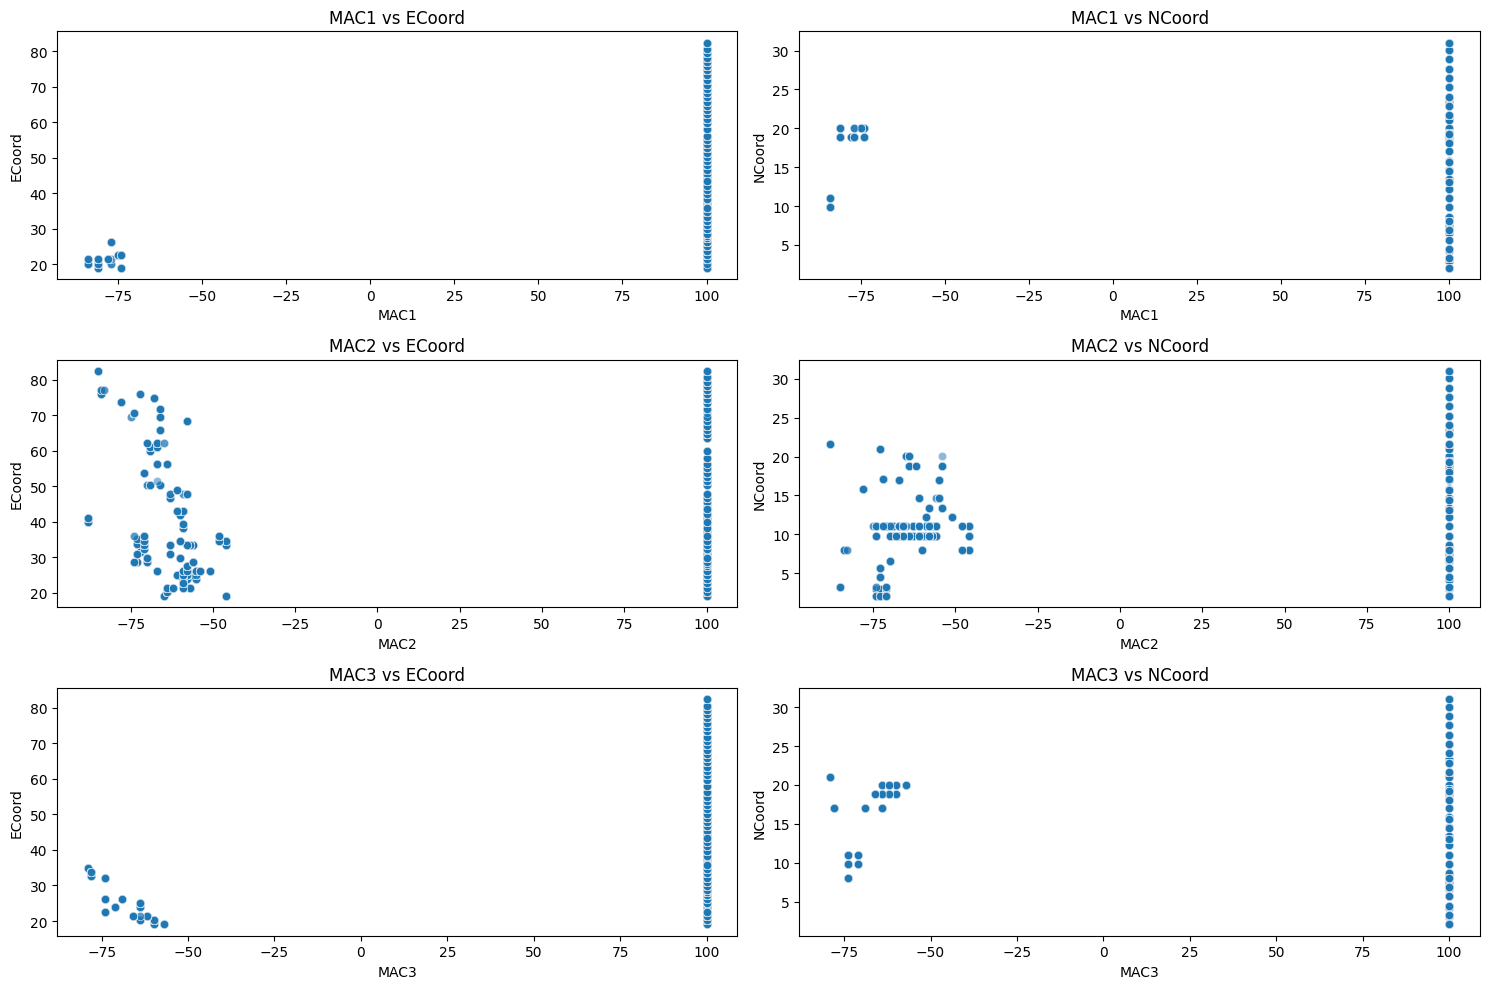

In [156]:
rssi_columns = ['MAC1', 'MAC2', 'MAC3']

# Setting up the plotting
fig, axes = plt.subplots(len(rssi_columns), len(output_variables), figsize=(15, 10))

for i, rssi_col in enumerate(rssi_columns):
    for j, output_var in enumerate(output_variables):
        # Scatter plot for each combination of RSSI value and output variable
        sns.scatterplot(x=train_data[rssi_col], y=train_data[output_var], ax=axes[i, j], alpha=0.5)
        axes[i, j].set_title(f'{rssi_col} vs {output_var}')

plt.tight_layout()
plt.show()

In [157]:
# Relevant data for training
X_train = train_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_train = train_data[output_variables]


In [158]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)

# The number of components after PCA
n_components = X_train.shape[1]

n_components

105

In [159]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# confirm scaling has been done properly
X_train.mean(), X_train.std()

(-1.6308037907835847e-18, 0.9999999999999999)

In [160]:
# Preprocessing testing data similarly
X_test = test_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_test = test_data[output_variables]

# Same PCA
X_test = pca.transform(X_test)

# Apply scaler
X_test = scaler.transform(X_test) 

In [161]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Training a linear regression model for ECoord
multi_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

e_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train['ECoord'], cv=5, scoring='neg_mean_squared_error')
n_cv_scores = cross_val_score(LinearRegression(), X_train, Y_train['NCoord'], cv=5, scoring='neg_mean_squared_error')

# Compute the average RMSE across the cross-validation folds
multi_average_rmse = (-multi_cv_scores.mean()) ** 0.5
e_avg_rmse = (-e_cv_scores.mean()) ** 0.5 
n_avg_rmse = (-n_cv_scores.mean()) ** 0.5

multi_average_rmse, (e_avg_rmse + n_avg_rmse)/2

(9.936644299771599, 9.936412460489262)

In [162]:
multi_model = LinearRegression().fit(X_train, Y_train)
e_model = LinearRegression().fit(X_train, Y_train['ECoord'])
n_model = LinearRegression().fit(X_train, Y_train['NCoord'])

y_pred = multi_model.predict(X_test)
predictions_df = pd.DataFrame(y_pred, columns=['Pred_ECoord', 'Pred_NCoord'])
multi_rmse_test = root_mean_squared_error(Y_test, predictions_df)
multi_r2_score = r2_score(Y_test, y_pred)

e_y_pred = e_model.predict(X_test)
n_y_pred = n_model.predict(X_test)

e_rmse_test = root_mean_squared_error(Y_test['ECoord'], e_y_pred)
n_rmse_test = root_mean_squared_error(Y_test['NCoord'], n_y_pred)

e_r2_score = r2_score(Y_test['ECoord'], e_y_pred)
n_r2_score = r2_score(Y_test['NCoord'], n_y_pred)

(multi_rmse_test, multi_r2_score), ((e_rmse_test + n_rmse_test)/2, (e_r2_score + n_r2_score)/2)

((5.011693766319956, 0.8330812512669606),
 (5.011693766319954, 0.8330812512669603))

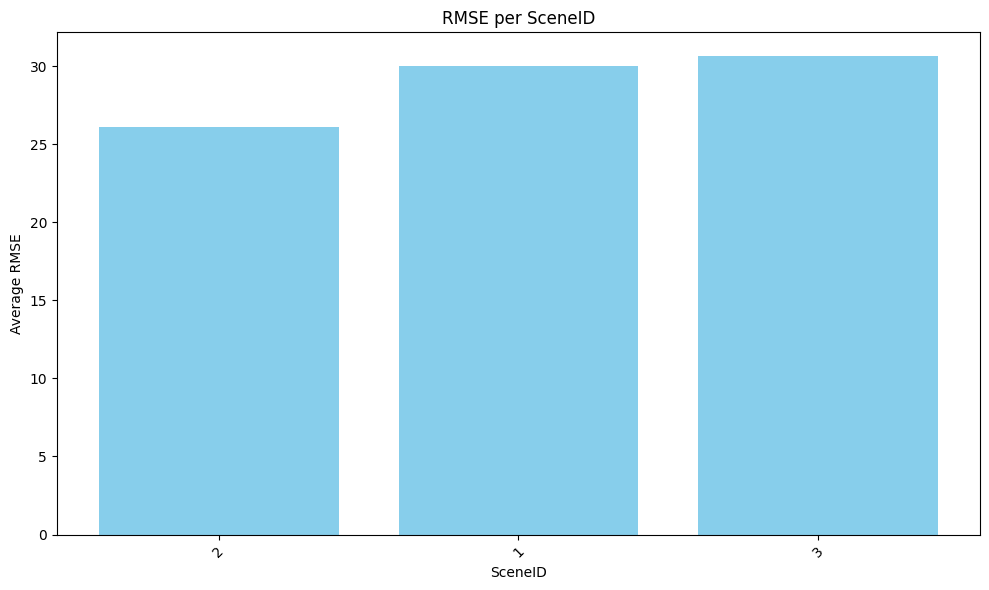

In [163]:
rmse_values = []

# Iterate over each SceneID
for scene_id in test_data['SceneID'].unique():
    # Filter the data for the current SceneID
    df_scene = test_data[test_data['SceneID'] == scene_id]
    
    X_scene = df_scene.drop(irrelevant_features, axis=1)
    y_true_scene = df_scene[['ECoord', 'NCoord']]
    
    X_scene = X_scene.replace(100, -200)

    X_scene = pca.transform(X_scene)  

    X_scene = scaler.transform(X_scene)

    y_pred_scene = model.predict(X_scene)

    rmse_ecoord = np.sqrt(mean_squared_error(y_true_scene['ECoord'], y_pred_scene[:, 0]))
    rmse_ncoord = np.sqrt(mean_squared_error(y_true_scene['NCoord'], y_pred_scene[:, 1]))
    
    rmse_avg = (rmse_ecoord + rmse_ncoord) / 2
    
    rmse_values.append((scene_id, rmse_avg))

rmse_df = pd.DataFrame(rmse_values, columns=['SceneID', 'RMSE'])

rmse_df = rmse_df.sort_values('RMSE')


plt.figure(figsize=(10, 6))
plt.bar(rmse_df['SceneID'].astype(str), rmse_df['RMSE'], color='skyblue')
plt.xlabel('SceneID')
plt.ylabel('Average RMSE')
plt.title('RMSE per SceneID')
plt.xticks(rotation=45)
plt.tight_layout()

It is necessary to check if all the assumptions for applying linear regression are met. So I define functions to check for homoscedacity and normality.

In [164]:
def residual_plot_both(y_pred, residuals):
    # Plot for ECoord
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.scatter(y_pred[:, 0], residuals['ECoord'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Predicted for ECoord')
    plt.xlabel('Predicted ECoord')
    plt.ylabel('Residuals')

    # Plot for NCoord
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.scatter(y_pred[:, 1], residuals['NCoord'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Predicted for NCoord')
    plt.xlabel('Predicted NCoord')

    plt.tight_layout()
    plt.show()

In [165]:
def qq_plot(residuals):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    stats.probplot(residuals['ECoord'], dist="norm", plot=plt)
    plt.title('Q-Q plot for ECoord residuals.')

    plt.subplot(1, 2, 2)
    stats.probplot(residuals['NCoord'], dist="norm", plot=plt)
    plt.title('Q-Q plot for NCoord residuals.')

    plt.tight_layout()
    plt.show()

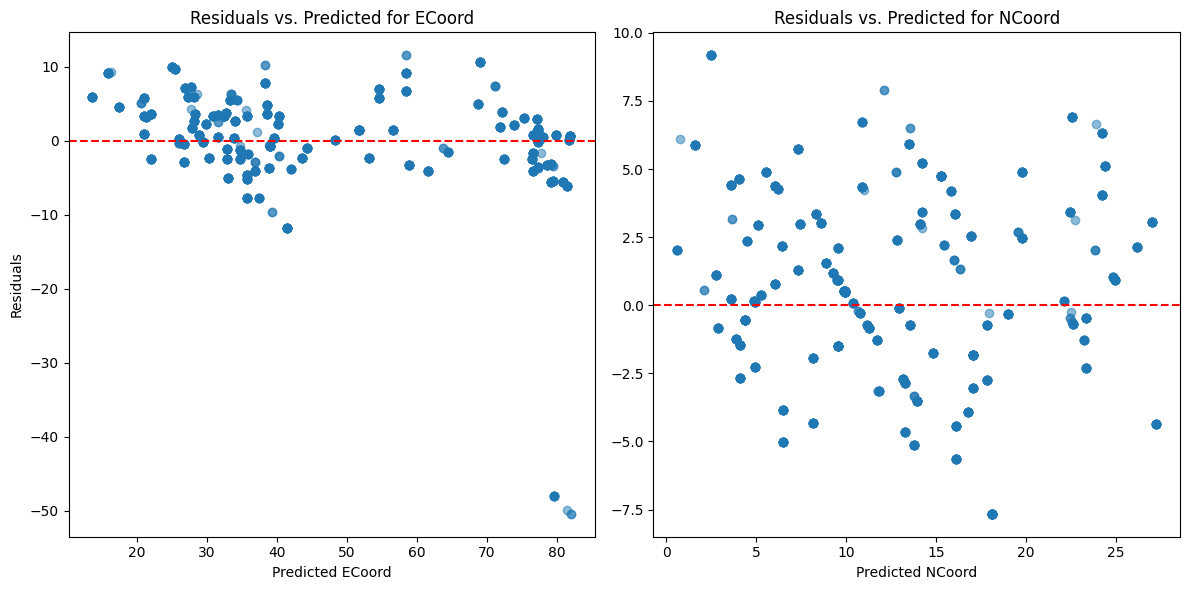

In [166]:
# both y_test and y_pred hold ECoord and NCoord values, except one is a dataframe the other is a numpy nd array resp.
residuals = Y_test - y_pred

residual_plot_both(y_pred, residuals)

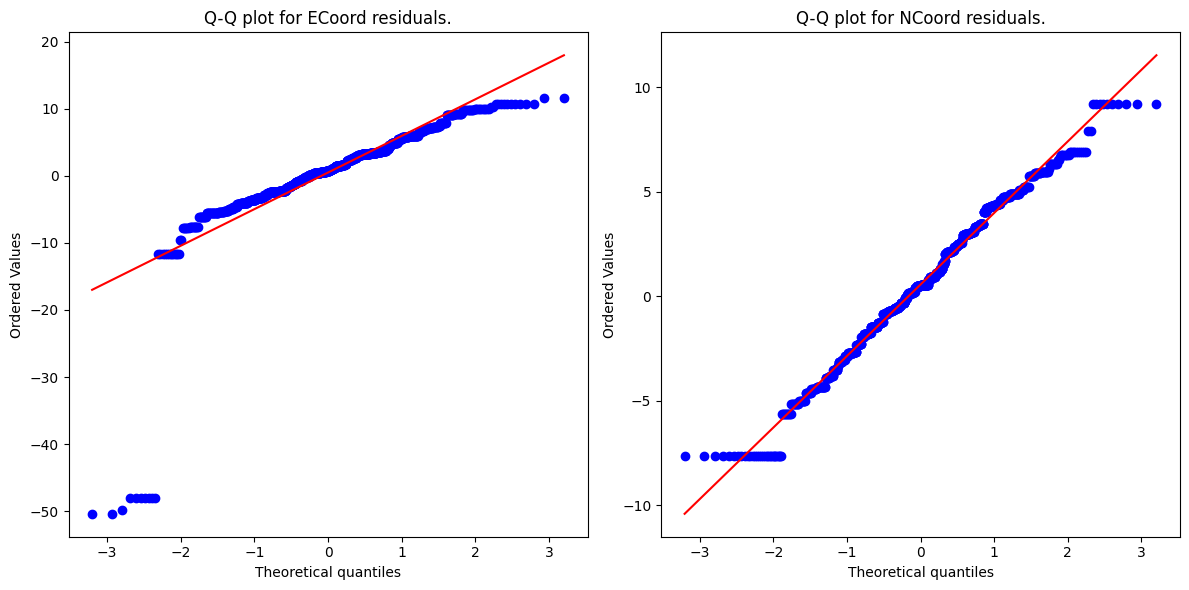

In [167]:
qq_plot(residuals)

The residual plots for ECoord and NCoord show that there is a pattern in the residuals for ECoord, with larger errors as the predicted value increases. This could indicate heteroscedasticity, which means the variance of the errors is not constant across all levels of the predictor variable. The residuals for NCoord seem more randomly scattered, but there is still some structure visible.
I will try to address that by removing outliers and/or log transforming first.

In [168]:
from scipy import stats

X_train = train_data.drop(irrelevant_features, axis=1).replace(100, -200)
X_test = test_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_train = train_data[output_variables]
Y_test = test_data[output_variables]

# Step 1: Remove outliers based on Z-score for ECoord and NCoord
z_scores = np.abs(stats.zscore(Y_train))
outliers = (z_scores > 3).any(axis=1)
X_train = X_train[~outliers]
Y_train = Y_train[~outliers]

Y_train_log = np.log1p(Y_train)

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, Y_train_log)

Y_train_pred = model.predict(X_train)
Y_train_pred = np.exp(Y_train_pred) - 1

Y_test_pred = model.predict(X_test)
Y_test_pred = np.exp(Y_test_pred) - 1

test_rmse = mean_squared_error(Y_test, Y_test_pred, squared=False)
train_rmse = mean_squared_error(Y_train, Y_train_pred, squared=False)

train_rmse, test_rmse

c:\Users\gps18.REMAINHEALTHY\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\gps18.REMAINHEALTHY\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(2.880195138847465, 5.490551214426581)

C:\Users\gps18.REMAINHEALTHY\AppData\Local\Temp\ipykernel_25896\515619399.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 100)


     ECoord  NCoord
523   76.03  20.050
602   34.28  29.480
526   76.03  20.050
31    26.23  19.440
616   32.13  30.080
585   34.98  21.960
444   73.63  12.850
732   31.98  17.072
76    25.03  12.850
411   74.83  10.450 [[81.72479486 12.8766354 ]
 [33.95975476 24.73462961]
 [81.72479486 12.8766354 ]
 [25.81118999 10.9193643 ]
 [31.90055407 27.56335408]
 [27.79651712 21.58474616]
 [63.6107704  13.39805639]
 [31.35098155 18.02996431]
 [19.76686523 15.4754718 ]
 [78.26407892  9.56064917]] [[-1.1697018   0.82114534 -0.9543212  ...  0.98951076 -1.63509787
   0.59425771]
 [ 1.04216773  1.54237007 -0.04630485 ...  0.81420466  0.02816077
   0.45441916]
 [-1.1697018   0.82114534 -0.9543212  ...  0.98951076 -1.63509787
   0.59425771]
 ...
 [ 1.10092119  0.6999161  -0.37189733 ...  1.5318736   0.78661529
   1.33981004]
 [ 1.30289478 -1.30035526 -0.90154922 ...  0.68765825 -0.92103603
  -1.5450632 ]
 [-1.36751867 -0.11377071 -0.3974702  ...  1.61023582 -0.01908226
  -0.23272617]]


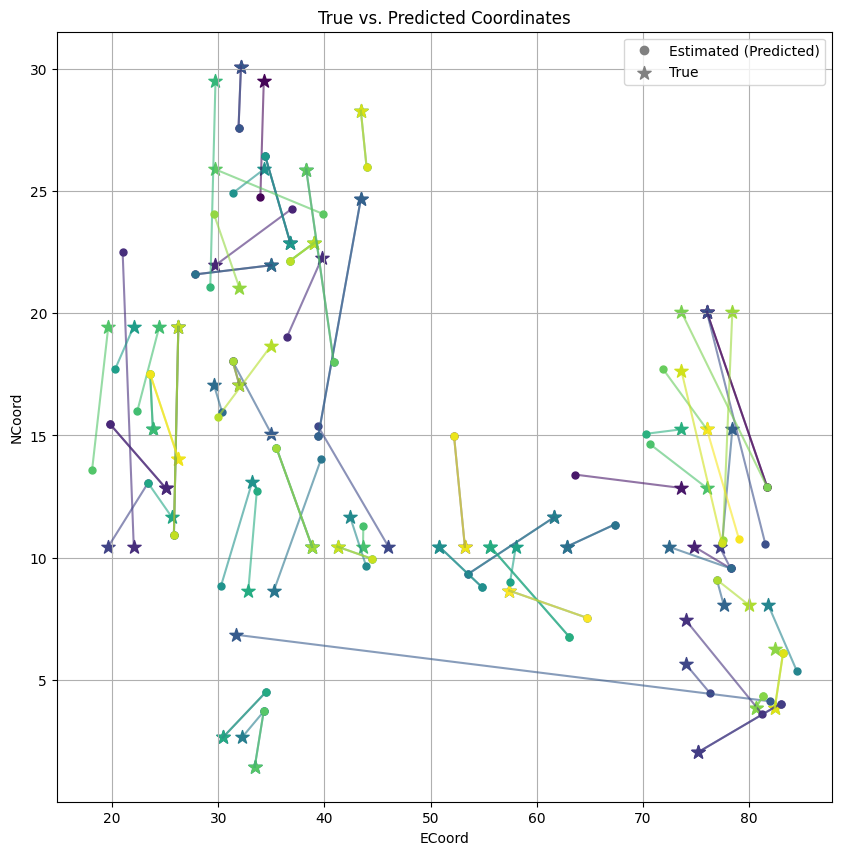

In [169]:
true_vs_predicted(X_test, Y_test, model, np.expm1)

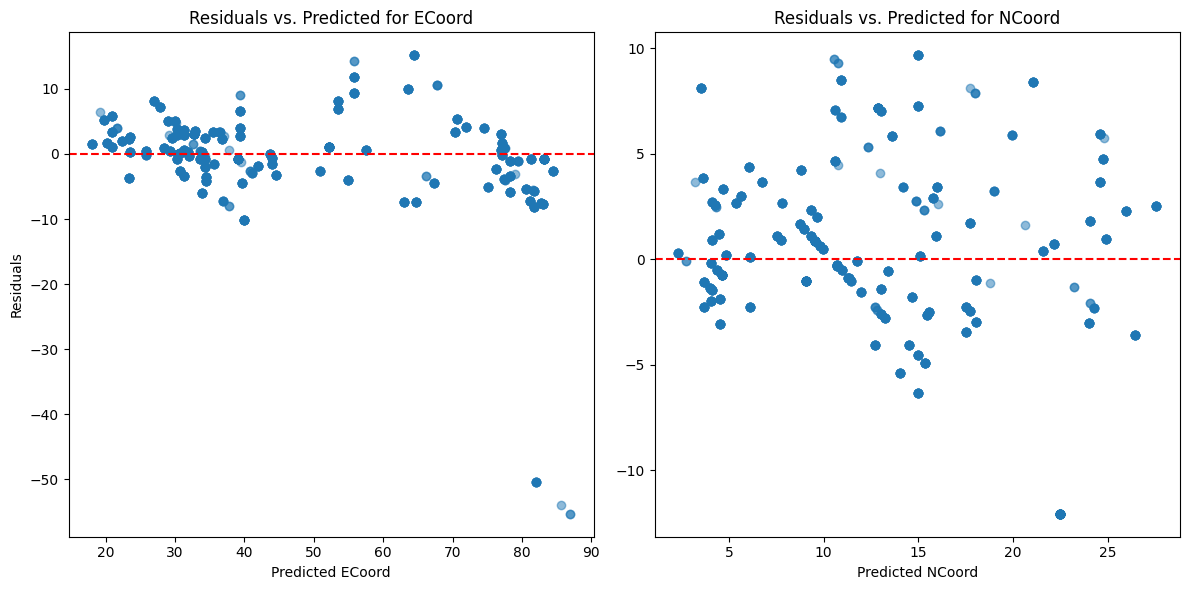

In [170]:
# Assuming `y_test` and `y_pred` are your true target values and predictions, respectively, each with two columns: ECoord and NCoord
residuals = Y_test - Y_test_pred  # Residuals for NCoord

residual_plot_both(Y_test_pred, residuals)

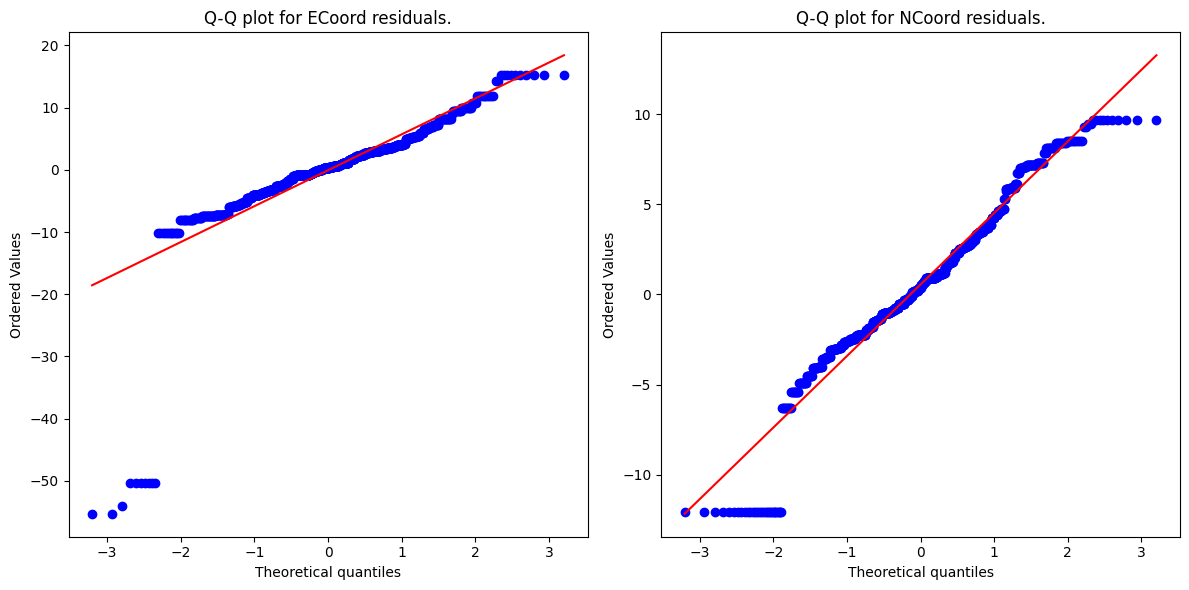

In [171]:
qq_plot(residuals)